# Notebook 3: Segmentación y etiquetado

La segmentación es el proceso de separar los objetos de interés del fondo. 
Es importante en nuestro caso, ya que para la detección de fuentes, queremos encontrar fuentes astronómicas individuales en las imágenes, separarlas y, por ejemplo, calcular su posición y guardarlas en diferentes recortes de imagen.

## Enfoque sencillo
El enfoque más sencillo para separar objetos en una imagen es, probablemente, el umbral de intensidad, que se realiza fácilmente con las funciones `numpy`.

Simulamos esto con una matriz de prueba `a`, y establecemos cada elemento de la matriz que sea mayor que 1 en 1:



In [11]:
a = np.array([[1,2,2,1,1,0],
              [0,2,3,1,2,0],
              [1,1,1,3,3,2],
              [1,1,1,1,2,1]])
np.where(a > 1, 1, 0)

array([[0, 1, 1, 0, 0, 0],
       [0, 1, 1, 0, 1, 0],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 1, 0]])

El resultado es una imagen binaria, en la que aún es necesario identificar y etiquetar los objetos individuales. La función label genera una matriz en la que a cada objeto se le asigna un número único:

La función `label` del paquete `ndimage` genera una matriz en la que los objetos de la entrada se etiquetan con un índice entero. Devuelve una tupla que consta de la matriz de etiquetas de objetos y el número de objetos encontrados, a menos que se proporcione el parámetro de salida, en cuyo caso solo se devuelve el número de objetos. La conectividad de los objetos se define mediante un elemento estructurante `s`. Por ejemplo, en 2D, el uso de un elemento estructurante de 4 conexiones da como resultado:

In [29]:
a = np.array([[0,1,1,0,0,0],[0,1,1,0,1,0],[0,0,0,1,1,1],[0,0,0,0,1,0]])
s = [[0, 1, 0], [1,1,1], [0,1,0]]

from scipy.ndimage import label
label(a, s)

(array([[0, 1, 1, 0, 0, 0],
        [0, 1, 1, 0, 2, 0],
        [0, 0, 0, 2, 2, 2],
        [0, 0, 0, 0, 2, 0]], dtype=int32),
 2)

Un elemento estructurante que define las conexiones de las características. La estructura debe ser centrosimétrica (véase Notas). Si no se proporciona ningún elemento estructurante, se genera automáticamente uno con una conectividad cuadrada igual a uno. Es decir, para una matriz de entrada 2-D, el elemento estructurante predeterminado es:

`[[0,1,0], [1,1,1], [0,1,0]]`


## Segmentación y etiquetado tras el filtrado

Basándonos en esto, combinamos las técnicas de filtrado del Cuaderno 2 con la función `label` que hemos visto aquí.
    
El objetivo es utilizar primero las técnicas de filtrado para resaltar los objetos de nuestra imagen astronómica y, a continuación, segmentarlos y etiquetarlos.


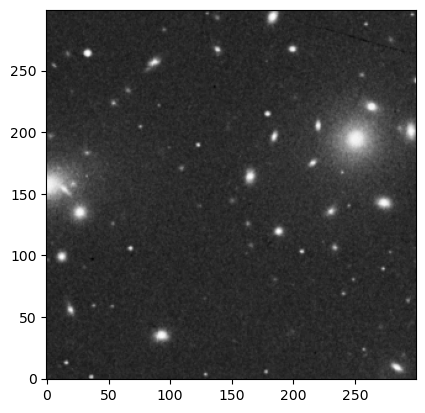

In [17]:
import numpy as np
from astropy.io import fits as fits
import matplotlib.pyplot as plt


# here we show again the image / Otra vez, mostramos la imagen.
image = fits.open('coma_DSSred.fits')
image = np.flipud(image[0].data)
    
fig = plt.figure()
plt.gray()  # show the filtered result in grayscale / Mostrar el resultado filtrado en escala de grises.
plt.imshow(image,origin='lower')


Ahora echamos un vistazo a la matriz subyacente que representa esta imagen:

In [4]:
print(image)

[[3157. 2969. 2969. ... 3301. 2985. 3143.]
 [2998. 2969. 3918. ... 3301. 2985. 3143.]
 [2682. 2969. 3918. ... 2985. 3301. 3301.]
 ...
 [2784. 3101. 3101. ... 3889. 3256. 2781.]
 [2784. 3101. 3101. ... 3256. 3256. 2781.]
 [3101. 3101. 2784. ... 2939. 3572. 3097.]]


Primero filtramos la imagen con un filtro máximo de `ndimage`:

In [42]:
from scipy import ndimage

new_image = image.byteswap().newbyteorder()  # force native byteorder

image_filtered = ndimage.maximum_filter(image, size=20)

print(image_filtered)

#with np.printoptions(threshold=np.inf):
#    print(image_filtered)


[[ 3457.  3457.  3457. ... 10634. 10634. 10634.]
 [ 3457.  3457.  3457. ... 10634. 10634. 10634.]
 [ 3615.  3615.  3615. ... 10634. 10634. 10634.]
 ...
 [ 4076.  4353.  4353. ... 12232. 10650.  7426.]
 [ 4076.  4353.  4353. ... 12232. 10650.  7426.]
 [ 4076.  4353.  4353. ... 12232. 10650.  7426.]]


Así es como se ve nuestra imagen después de aplicar el filtro máximo:

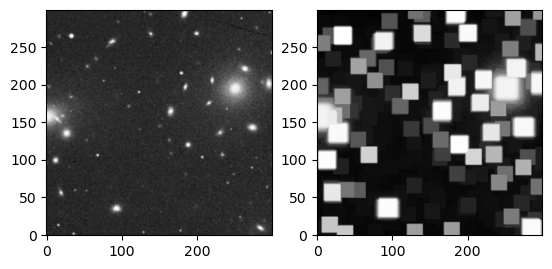

In [19]:
fig = plt.figure()
plt.gray() 

ax1 = fig.add_subplot(121)  # left side / lado izquierdo
ax2 = fig.add_subplot(122)  # right side / lado derecho

#images are often displayed with origin (0,0) at the left upper corner, but we want (0,0) to be in the 
#left lower corner

#Las imágenes suelen mostrarse con el origen (0,0) en la esquina superior izquierda, 
#pero queremos que (0,0) esté en la esquina inferior izquierda.
ax1.imshow(image,origin='lower') 
ax2.imshow(image_filtered,origin='lower')


plt.show()

Ahora continuamos con el etiquetado de la imagen. Como paso previo, seleccionaremos el nivel de brillo que consideramos como un objeto detectado en la imagen.

(**Sugerencia:** puede modificar este valor. También puede filtrar un intervalo, es decir, entre dos valores).

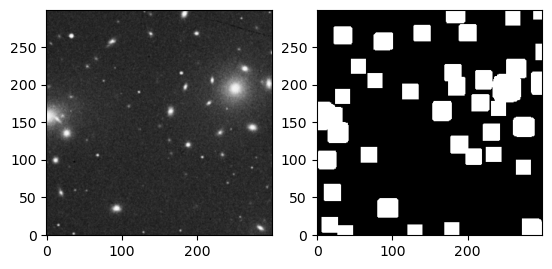

In [20]:

image_filtered_mod = np.where(image_filtered > 10000, 1, 0)

fig = plt.figure()
plt.gray()  # show the filtered result in grayscale

ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side

ax1.imshow(image,origin='lower') #images are often displayed with origin (0,0) at the left upper corner, but we want (0,0) to be in the left lower corner
ax2.imshow(image_filtered_mod,origin='lower')


plt.show()


Aquí realizamos una segmentación y etiquetado similares a los del Notebook 2:

In [26]:
#An array-like object to be labeled. Any non-zero values in input are counted as features and zero values are considered the background.

#Un objeto (matriz) que se va a etiquetar. Cualquier valor distinto de cero en la entrada se cuenta como característica 
#y los valores cero se consideran fondo.

s = [[1,1,1], [1,1,1], [1,1,1]]
labeled_image, num_features=ndimage.label(image_filtered_mod,s)

# this is the number of objects it finds / este es el número de objetos que encuentra
print('num_features')
print(num_features)

# the minimum and maximum label / La etiqueta mínima y máxima
print(np.min(labeled_image))
print(np.max(labeled_image))

#the 1 in the image array changed to values 1 - 31 according to the label of the object found
#El 1 de la matriz de imágenes cambió a valores entre 1 y 31 según la etiqueta del objeto encontrado.
print('labeled_image')
print(labeled_image)

num_features
31
0
31
labeled_image
[[ 0  0  0 ...  4  4  0]
 [ 0  0  0 ...  4  4  0]
 [ 0  0  0 ...  4  4  0]
 ...
 [ 0  0  0 ... 31 31 31]
 [ 0  0  0 ... 31 31 31]
 [ 0  0  0 ... 31 31 31]]


Con eso hemos etiquetado la imagen. Ahora queremos segmentarla, lo que significa extraer los objetos etiquetados y con ellos:
* tamaño
* posición

Esto es bastante fácil, ya que el algoritmo solo necesita agrupar todo lo que tenga el mismo valor > 0.

## Segmentación

Para el proceso de segmentación, se puede utilizar la función `find_objects` para generar una lista de segmentos que, para cada objeto, proporcionan la submatriz más pequeña que contiene completamente el objeto:

La función find_objects encuentra todos los objetos en una matriz etiquetada y devuelve una lista de segmentos que corresponden a las regiones más pequeñas de la matriz que contienen el objeto.

Primero hacemos un ejemplo con nuestra matriz de prueba `a`:

In [29]:
a = np.array([[0,1,1,0,0,0],[0,1,1,0,1,0],[0,0,0,1,1,1],[0,0,0,0,1,0]])
l, n = ndimage.label(a)
from scipy.ndimage import find_objects
f = find_objects(l)

print(a)

print(a[f[0]])

print(a[f[1]])

[[0 1 1 0 0 0]
 [0 1 1 0 1 0]
 [0 0 0 1 1 1]
 [0 0 0 0 1 0]]
[[1 1]
 [1 1]]
[[0 1 0]
 [1 1 1]
 [0 1 0]]


Vemos que la matriz `a` contiene dos objetos, que son redondeados por `find_index` y pueden extraerse. Con eso podemos continuar y llevar a cabo lo mismo en nuestra imagen astronómica.

In [33]:
f = find_objects(labeled_image)

#we get the positions of the objects found / obtenemos las posiciones de los objetos encontrados
print(f)

#the first three objects - you could get all with a loop over the index, running from 0 to num_features-1

#los tres primeros objetos: se pueden obtener todos con un bucle sobre el índice, que va desde 0 hasta num_features-1.
print(labeled_image[f[0]])
print(labeled_image[f[1]])
print(labeled_image[f[2]])

[(slice(0, 24, None), slice(6, 48, None)), (slice(0, 14, None), slice(120, 140, None)), (slice(0, 17, None), slice(169, 189, None)), (slice(0, 22, None), slice(272, 299, None)), (slice(23, 49, None), slice(80, 108, None)), (slice(45, 68, None), slice(9, 32, None)), (slice(80, 100, None), slice(264, 284, None)), (slice(87, 112, None), slice(1, 26, None)), (slice(93, 132, None), slice(177, 219, None)), (slice(96, 117, None), slice(58, 80, None)), (slice(97, 117, None), slice(224, 245, None)), (slice(122, 177, None), slice(0, 42, None)), (slice(125, 148, None), slice(220, 243, None)), (slice(130, 157, None), slice(260, 289, None)), (slice(151, 178, None), slice(153, 179, None)), (slice(158, 234, None), slice(210, 278, None)), (slice(164, 187, None), slice(205, 229, None)), (slice(174, 194, None), slice(24, 44, None)), (slice(180, 201, None), slice(113, 135, None)), (slice(185, 227, None), slice(169, 197, None)), (slice(186, 217, None), slice(284, 300, None)), (slice(195, 215, None), slice

## Mediciones de objetos

Dada una matriz de objetos etiquetados, se pueden medir las propiedades de cada uno de los objetos.

La lista de segmentos generada por `find_objects` es útil para encontrar la posición y las dimensiones de los objetos en la matriz, pero también se puede utilizar para realizar mediciones en los objetos individuales. Supongamos que queremos encontrar los centros de los objetos en una imagen:

In [35]:
image = np.arange(4 * 6).reshape(4, 6)
mask = np.array([[0,1,1,0,0,0],[0,1,1,0,1,0],[0,0,0,1,1,1],[0,0,0,0,1,0]])
labels = ndimage.label(mask)[0]
slices = find_objects(labels)
print(image)
print(labels)
print(slices)

[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]]
[[0 1 1 0 0 0]
 [0 1 1 0 2 0]
 [0 0 0 2 2 2]
 [0 0 0 0 2 0]]
[(slice(0, 2, None), slice(1, 3, None)), (slice(1, 4, None), slice(3, 6, None))]


Ahora calcula el centro de masa de los valores de una matriz en las etiquetas:

In [37]:
b = np.array(([0,1,1,0,0,0,0,1,1,1,0],
              [0,1,0,0,0,0,0,1,1,1,0],
              [0,0,0,0,0,0,0,1,1,1,0],
              [0,0,1,1,0,0,0,0,0,0,0],
              [0,0,1,1,0,0,0,0,0,0,0]))
lbl = ndimage.label(b)[0]

print('lbl')
print(lbl)
com=ndimage.center_of_mass(b, lbl, [1,2,3])#, [1,2,3]
print('com')
print(com)


lbl
[[0 1 1 0 0 0 0 2 2 2 0]
 [0 1 0 0 0 0 0 2 2 2 0]
 [0 0 0 0 0 0 0 2 2 2 0]
 [0 0 3 3 0 0 0 0 0 0 0]
 [0 0 3 3 0 0 0 0 0 0 0]]
com
[(0.3333333333333333, 1.3333333333333333), (1.0, 8.0), (3.5, 2.5)]


Podemos comparar los centros con los índices y ver que coinciden: el primer objeto, por ejemplo, se extiende desde la fila con índice 0 hasta el índice 1 (con más píxeles en la fila 0)
y se extiende entre las columnas con índices 1 y 2.

## Un ejemplo completo sobre la extracción de fuentes

Aquí vemos un ejemplo completo sobre cómo extraer fuentes de imágenes astronómicas, reuniendo todos los fragmentos de código que hemos visto hasta ahora:

num_features: the number ob objects found
31
com: the centers of the individual objects
[(9.411650485436894, 183.47766990291262), (7.0, 293.0), (12.5, 259.5), (32.05850091407678, 199.56124314442414), (32.52087475149106, 139.02186878727633), (35.51939291736931, 33.94097807757167), (43.49508196721312, 87.54262295081968), (57.5, 294.5), (76.5, 54.5), (101.1684464347227, 246.61109197382018), (94.47272727272727, 182.5939393939394), (98.97341513292433, 291.60327198364007), (95.5, 76.5), (110.02169197396964, 123.4772234273319), (116.5, 33.5), (124.981718464351, 216.43875685557586), (135.92565597667638, 165.47084548104957), (151.3050944476245, 19.845449341728678), (157.04376657824935, 274.05437665782495), (164.0, 231.0), (187.7517039922103, 197.13826679649463), (194.0, 68.5), (193.5, 234.0), (200.9071661237785, 12.944625407166123), (210.5, 273.5), (244.0, 20.0), (264.6150627615063, 93.55230125523012), (289.2375533428165, 23.714082503556188), (289.13059033989265, 284.82647584973165), (291.5, 17

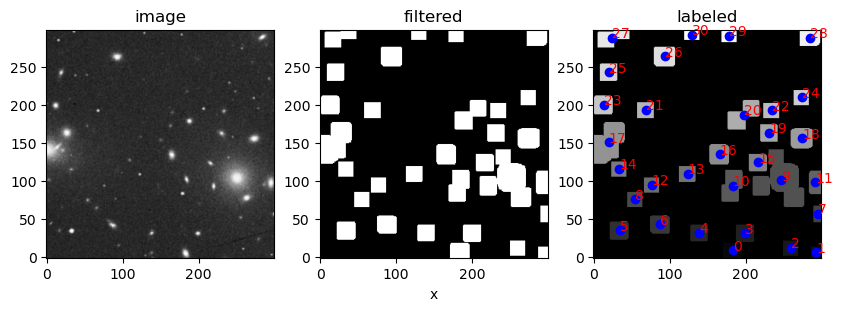

cutout
(0, 20, 171, 197)


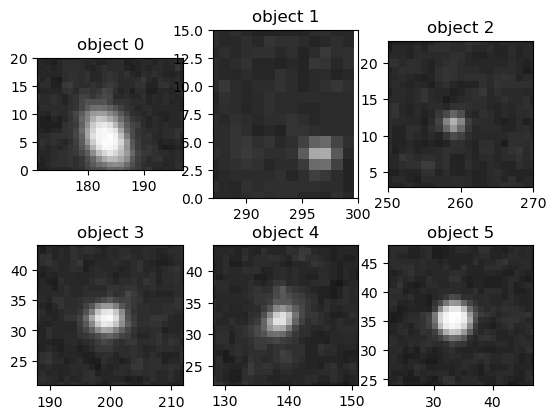

In [41]:
from scipy import ndimage
import numpy as np


# we load the image / cargamos la imagen
image = fits.open('coma_DSSred.fits')
image = image[0].data
new_image = image.byteswap().newbyteorder()  # force native byteorder

#we apply a maximum filter - you can change it to a different filter
#Aplicamos un filtro máximo; puedes cambiarlo por otro filtro diferente.
image_filtered = ndimage.maximum_filter(image, size=20)

#we set a threshold above which we recognize an object - you can change it to a different value
#establecemos un umbral por encima del cual reconocemos un objeto; puedes cambiarlo a un valor diferente.
image_filtered = np.where(image_filtered > 10000, 1, 0)

#the structuring element s - you can change it
#el elemento estructurante s: puedes cambiarlo
s = [[1, 1, 1], [1,1,1], [1,1,1]]
lab, num_features=ndimage.label(image_filtered,s)

#this should give us how many objects are found
#Esto debería indicarnos cuántos objetos se han encontrado.
print('num_features: the number ob objects found')
print(num_features)

#the centers of the individual objects
#los centros de los objetos individuales
com=ndimage.center_of_mass(image_filtered, lab, np.arange(1,num_features+1))
print('com: the centers of the individual objects')
print(com)

print('loc: the location of found objects')
loc=ndimage.find_objects(lab)#[0]

# Find the location of all objects
# Encuentra la ubicación de todos los objetos

print('measurements: get height and width of all found objects')
# Get the height and width / Obtener la altura y la anchura
measurements = []
for ob in loc:
    measurements.append((int(ob[0].start), int(ob[0].stop), int(ob[1].start), int(ob[1].stop)))

print(measurements)


fig = plt.figure(figsize=(10,6))

plt.gray()  # show the images in grayscale / Mostrar las imágenes en escala de grises.

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132) 
ax3 = fig.add_subplot(133)  



ax1.imshow(new_image,origin='lower')
ax2.imshow(image_filtered,origin='lower')
ax3.imshow(lab,origin='lower')


ax1.set_title('image')
ax2.set_title('filtered')
ax3.set_title('labeled')

i=0
for coord in com:
   ax3.scatter(coord[1],coord[0],color='blue')
   ax3.annotate("%i"%i,(coord[1],coord[0]),color='red')
   i=i+1



ax2.set_xlabel('x')

plt.show()


# We now extract the measurements for a few example objects to plot them

# Ahora extraemos las medidas de algunos objetos de ejemplo para representarlos gráficamente.

m1=measurements[0]
object0 = image[m1[0]:m1[1],m1[2]:m1[3]]

m2=measurements[1]
object1 = image[m2[0]:m2[1],m2[2]:m2[3]]

m3=measurements[2]
object2 = image[m3[0]:m3[1],m3[2]:m3[3]]

m4=measurements[3]
object3 = image[m4[0]:m4[1],m4[2]:m4[3]]

m5=measurements[4]
object4 = image[m5[0]:m5[1],m5[2]:m5[3]]

m6=measurements[5]
object5 = image[m6[0]:m6[1],m6[2]:m6[3]]


fig = plt.figure()

plt.gray()  # show the filtered result in grayscale / Mostrar el resultado filtrado en escala de grises.

ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232) 
ax3 = fig.add_subplot(233)  
ax4 = fig.add_subplot(234)  
ax5 = fig.add_subplot(235)  
ax6 = fig.add_subplot(236)  




# give correct pixel coords / proporcionar las coordenadas de píxeles correctas


ax1.imshow(image,origin='lower')
ax1.set_xlim(m1[2],m1[3])
ax1.set_ylim(m1[0],m1[1])

ax2.imshow(image,origin='lower')
ax2.set_xlim(m2[2],m2[3])
ax2.set_ylim(m2[0],m2[1])

ax3.imshow(image,origin='lower')
ax3.set_xlim(m3[2],m3[3])
ax3.set_ylim(m3[0],m3[1])

ax4.imshow(image,origin='lower')
ax4.set_xlim(m4[2],m4[3])
ax4.set_ylim(m4[0],m4[1])

ax5.imshow(image,origin='lower')
ax5.set_xlim(m5[2],m5[3])
ax5.set_ylim(m5[0],m5[1])

ax6.imshow(image,origin='lower')
ax6.set_xlim(m6[2],m6[3])
ax6.set_ylim(m6[0],m6[1])

ax1.set_title('object 0')
ax2.set_title('object 1')
ax3.set_title('object 2')
ax4.set_title('object 3')
ax5.set_title('object 4')
ax6.set_title('object 5')

plt.show()

## Tu tarea

Ejecuta el código. Ejecútalo también en las otras imágenes astronómicas proporcionadas. Con esto tendrás una versión básica de un proceso de extracción de fuentes.

¿Crees que la extracción de objetos funciona bien? Modifícalo para que se extraigan tanto los objetos más tenues como los más brillantes.
Para ello, puedes utilizar el código que se encuentra en «Un ejemplo completo de extracción de fuentes» y modificarlo tal y como se describe en los comentarios del código.

### Más avanzado

Una tarea más avanzada sería escribir las imágenes en archivos, así como crear una tabla que contenga las coordenadas de los objetos. Esto es similar a crear un catálogo astronómico (a pesar de que aquí estamos trabajando con coordenadas de imagen y no con coordenadas astronómicas, es decir, aún no sabemos dónde se encuentran estos objetos en el cielo).

También puedes consultar la documentación de `ndimage` y aplicar las funciones útiles que allí se encuentran.